In [1]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

In [2]:
%load_ext autoreload
%autoreload 2
from dataset import *
from MapMatching import MapMatching
import copy
from tracker import StaticTracker
from dynamic_tracker import ClassicDBSCAN, DynamicTracker
from simulation import NuscenesSimulation

In [3]:
class RadarLocalizer():
    def __init__(self, **kwargs):
        self.static_tracker = StaticTracker()
        self.cluster_model = ClassicDBSCAN()
        self.dynamic_tracker = DynamicTracker()
        self.map_matching = MapMatching(N=200)
        self.mm = kwargs.pop('mm', False)
        self.estimated_relative_pos = np.array([0,0])
        
    def runDynamicTracker(self, dw, video_data, first_world_ref, imu_relative_ref):
        heading = np.deg2rad(video_data["heading_imu"]-90)
        Z, X = self.cluster_model.run(pc=dw, ego=video_data["pos_imu"], heading=heading) # Z in radar coordinates
        self.dynamic_tracker.run(Z, video_data["timestamp"], {"heading": heading, "T": video_data["pos_imu"]}, video_data["veh_speed"])
    
        return self.dynamic_tracker.getTracks(), {"Z": Z, "X": X}
    
    def runStaticTracker(self, zw, covw, prior, video_data, first_world_ref, imu_relative_ref):
        #translate measurements and priors relative to the first position [floating point precision reasons]
        zw = self.translateMeasurements(zw, first_world_ref)
        prior_list = self.getPriorList(prior, first_world_ref[0:2] - imu_relative_ref + self.estimated_relative_pos)
        #run static tracker
        points, polynoms = self.static_tracker.run(zw,covw,prior_list)
        print("video_data[pos]", video_data["pos"])
        points, polynoms = self.translateOutput(points, polynoms, -1*video_data["pos"][0:2] + imu_relative_ref) #output from ego(GT) prespective
        
        return points, polynoms, self.static_tracker.getDebugInfo()
        
    def runMapMatching(self, video_data, first_world_ref, imu_relative_ref, nusc_map):
        if self.mm:
            extended_tracks = self.static_tracker.getExtendedTracks()
            imu_relative_ref_3d = np.array([imu_relative_ref[0], imu_relative_ref[1], np.deg2rad(video_data["heading_imu"]-90)])
            self.map_matching.run(extended_tracks, nusc_map, first_world_ref, imu_relative_ref_3d)
            gt_relative_pos = np.array([video_data["pos"][0] - first_world_ref[0], video_data["pos"][1] - first_world_ref[1], video_data["pos"][2]]) 
            mm_results = self.map_matching.getResults(extended_tracks, gt_relative_pos)
            mm_results["pf_best_pos"] += first_world_ref[0:2]
            mm_results["pf_mean_pos"] += first_world_ref[0:2]
            
            return mm_results
        
    def translatePolynom(self, c, xstart, xend, pos):
        x = np.array([xstart, 0.5*(xstart+xend), xend])
        x_trns = x - pos[0]
        y = np.array([c[0]*x[0]**2+c[1]*x[0]+c[2], c[0]*x[1]**2+c[1]*x[1]+c[2], c[0]*x[2]**2+c[1]*x[2]+c[2]])
        y_trns = y - pos[1]
        A = [[x_trns[0]**2, x_trns[0], 1],[x_trns[1]**2, x_trns[1], 1],[x_trns[2]**2, x_trns[2], 1]]
        c = np.linalg.inv(A).dot(y_trns)
        
        return c
    
    def getPriorList(self, prior, translation):            
        lanes = copy.deepcopy(prior)
        lanes = self.translatePrior(translation, lanes)

        prior_list = []
        for lane in lanes:
            (a0,a1,a2) = lane["poly"].c[2], lane["poly"].c[1], lane["poly"].c[0]
            prior_list.append({"c": (a0,a1,a2), "xmin": np.min(lane["x"]), "xmax": np.max(lane["x"])})
            
        return prior_list
        
    def translatePrior(self, pos, prior):
        for pr in prior:
            min_x = np.min(pr["x"])
            max_x = np.max(pr["x"])
            c = self.translatePolynom(pr["poly"].c, min_x, max_x, pos)
            pr["poly"] = np.poly1d(c)
            pr["x"] -= pos[0]
        
        return prior
    
    def translateMeasurements(self, zw, pos):
        return zw - pos
        
    def translateOutput(self, points, polynoms, pos):
        points = points - pos
        for polynom in polynoms:
            c = self.translatePolynom(polynom["f"].c, polynom["x_start"], polynom["x_end"], pos)
            polynom["f"] = np.poly1d(c)
            polynom["x_start"] -= pos[0]
            polynom["x_end"] -= pos[0]
        
        return points, polynoms
    
    def run(self, static_data, dynamic_data, video_data, prior, first_world_ref, nusc_map):
        #run static tracker
        imu_relative_ref = video_data["pos_imu"][0:2]-first_world_ref
        points, polynoms, debug_info = self.runStaticTracker(static_data["zw"], static_data["covw"], prior, video_data, first_world_ref, imu_relative_ref)
        #run dynamic tracker
        dynamic_tracks, dynamic_clusters = self.runDynamicTracker(dynamic_data["dw"], video_data, first_world_ref, imu_relative_ref)
        #Run map-matching
        mm_results = self.runMapMatching(video_data, first_world_ref, imu_relative_ref, nusc_map)
        self.estimated_relative_pos = mm_results["pf_mean_pos"] - first_world_ref
        return points, polynoms, dynamic_tracks, dynamic_clusters, debug_info, mm_results

In [ ]:
scene = 690 #365
model = RadarLocalizer(scene_id=scene, mm=True)
video_list={'video' : True, 'video_debug': True, 'video_pf': True, 'video_pf_xy': False, 'dynamic_tracker': True}
sim = NuscenesSimulation(nusc=nusc, model=model, scene_id=scene, Nmax=1200, video_list=video_list)
sim.run(start=0, N=50, generate_video=False, video_with_priors=True, debug=False)

scene_id=690 scene_name=scene-0904 map_name=boston-seaport


/home/kfir/workspace/RadarLocalization/dataset.py:306: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


odom_speed [[1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 [1.53729795e+15 9.00000000e+00]
 ...
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]
 [1.53729811e+15 3.70000000e+01]]


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in s

frame 0
Number of point tracks before run() 0
Number of extended tracks before run() 0
video_data[pos] [1114.93531372 1589.04348036    0.        ]
frame_idx = 1
Number of new plots 2
Number of dynamic tracks before run() 0
trk.kf.x = [[7.62498588]
 [2.67594329]
 [1.17947535]
 [0.41392983]] age = 1 hits = 1
trk.kf.x = [[7.62498588]
 [2.67594329]
 [1.17947535]
 [0.41392983]] age = 1 hits = 1
last_output [0. 0.]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1122.5960584670038, 1205.0298324517128] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0


No handles with labels found to put in legend.


frame 1


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 45
Number of extended tracks before run() 0


/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 5.89225009e+00 -1.07880763e+00  4.75946526e-03  3.69680995e+01
  5.33584103e+01] static_cars_flag True
video_data[pos] [1115.11507448 1588.94254053    0.        ]
frame_idx = 2
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[7.71119535]
 [2.70302666]
 [1.12827676]
 [0.41333999]] age = 2 hits = 1
trk.kf.x = [[7.71119535]
 [2.70302666]
 [1.12827676]
 [0.41333999]] age = 2 hits = 1
trk.kf.x = [[19.62315315]
 [ 2.2714462 ]
 [ 1.98673432]
 [ 0.2299712 ]] age = 1 hits = 1
last_output [0.01028087 0.01485066]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1119.3484809377017, 1205.0298324517128] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 1 cost_true [3.453257379903904] cost_mean [1.3478427214828974]
frame 2


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 61
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1115.29705166 1588.84075007    0.        ]
frame_idx = 3
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[7.790556  ]
 [2.73384205]
 [1.05779826]
 [0.41331665]] age = 3 hits = 1
trk.kf.x = [[7.790556  ]
 [2.73384205]
 [1.05779826]
 [0.41331665]] age = 3 hits = 1
trk.kf.x = [[19.84295851]
 [ 2.32041895]
 [ 2.01191468]
 [ 0.24145128]] age = 2 hits = 2
trk.kf.x = [[ 18.9445605 ]
 [-14.97486368]
 [  2.15739529]
 [ -1.70532858]] age = 1 hits = 1
last_output [ 0.21054137 -0.10074053]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.8456230627937, 1205.0298324517128] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 1 cost_true [3.2645734596731013] cost_mean [1.3515411277347065]
frame 3


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 79
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1115.49526454 1588.72898093    0.        ]
frame_idx = 4
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[7.86524816]
 [2.76302485]
 [0.98823634]
 [0.41309108]] age = 4 hits = 1
trk.kf.x = [[7.86524816]
 [2.76302485]
 [0.98823634]
 [0.41309108]] age = 4 hits = 1
trk.kf.x = [[19.98906406]
 [ 2.33395298]
 [ 1.94231351]
 [ 0.24100793]] age = 3 hits = 2
trk.kf.x = [[ 19.09758863]
 [-15.10703776]
 [  2.08734973]
 [ -1.70580509]] age = 2 hits = 1
trk.kf.x = [[9.85640329]
 [9.66544544]
 [1.24948139]
 [1.22527395]] age = 1 hits = 1
trk.kf.x = [[20.54856659]
 [ 0.58394886]
 [ 2.99878936]
 [ 0.08521955]] age = 1 hits = 1
last_output [ 0.40004292 -0.21325144]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.0298324517128] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 1 cost_true [4.273943393947602] cost_mean [1.8063689051698466]
frame 4


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 89
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.8373928807050899, -0.8464994861568061, 0.009680788591780985) (0.0, -0.6251028300674177, -0.0007622677274035345)
video_data[pos] [1115.70495316 1588.6101875     0.        ]
frame_idx = 5
Number of new plots 1
Number of dynamic tracks before run() 6
trk.kf.x = [[7.93534393]
 [2.79141011]
 [0.92190699]
 [0.41278722]] age = 5 hits = 1
trk.kf.x = [[7.93534393]
 [2.79141011]
 [0.92190699]
 [0.41278722]] age = 5 hits = 1
trk.kf.x = [[20.13061316]
 [ 2.34540416]
 [ 1.87592738]
 [ 0.24038958]] age = 4 hits = 2
trk.kf.x = [[ 19.24422495]
 [-15.24139589]
 [  2.02032187]
 [ -1.70647114]] age = 3 hits = 1
trk.kf.x = [[9.94839968]
 [9.7541186 ]
 [1.18341975]
 [1.22488393]] age = 2 hits = 1
trk.kf.x = [[20.62216759]
 [ 0.44272923]
 [ 3.04002674]
 [ 0.08465312]] age = 2 hits = 2
last_output [ 0.58552168 -0.32089515]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.041446459925] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 1 cost_true [5.944657653707355] cost_mean [2.7676661070369266]
frame 5


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 94
Number of extended tracks before run() 1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1115.90972548 1588.49370469    0.        ]
frame_idx = 6
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[8.00165662]
 [2.81999318]
 [0.8736101 ]
 [0.41252944]] age = 6 hits = 1
trk.kf.x = [[8.00165662]
 [2.81999318]
 [0.8736101 ]
 [0.41252944]] age = 6 hits = 1
trk.kf.x = [[20.26830707]
 [ 2.35744377]
 [ 1.82757958]
 [ 0.23985028]] age = 5 hits = 2
trk.kf.x = [[ 19.38751047]
 [-15.3750416 ]
 [  1.97139956]
 [ -1.70705296]] age = 4 hits = 1
trk.kf.x = [[10.03638895]
 [ 9.84297955]
 [ 1.13536249]
 [ 1.22454894]] age = 3 hits = 1
trk.kf.x = [[21.12158953]
 [ 0.3811342 ]
 [ 2.99847393]
 [ 0.0805817 ]] age = 3 hits = 3
trk.kf.x = [[11.22276851]
 [ 2.25971825]
 [ 1.47048766]
 [ 0.2960845 ]] age = 1 hits = 1
last_output [ 0.80954264 -0.44686529]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.0932127932058] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 1 cost_true [6.210445843742879] cost_mean [2.8903422442079534]
frame 6


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 111
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1116.34017475 1588.2474085     0.        ]
frame_idx = 7
Number of new plots 2
Number of dynamic tracks before run() 7
trk.kf.x = [[8.40755879]
 [2.61208036]
 [1.25323259]
 [0.53837225]] age = 7 hits = 2
trk.kf.x = [[8.11569459]
 [2.87585073]
 [0.74601406]
 [0.411974  ]] age = 7 hits = 1
trk.kf.x = [[20.52512192]
 [ 2.37814929]
 [ 1.69985468]
 [ 0.23858448]] age = 6 hits = 2
trk.kf.x = [[ 19.65248307]
 [-15.64582601]
 [  1.84222477]
 [ -1.70842533]] age = 5 hits = 1
trk.kf.x = [[10.19502325]
 [10.01913496]
 [ 1.00837108]
 [ 1.22379836]] age = 4 hits = 1
trk.kf.x = [[21.82695411]
 [ 0.52499411]
 [ 2.69760098]
 [ 0.09658782]] age = 4 hits = 4
trk.kf.x = [[11.42593739]
 [ 2.29563785]
 [ 1.34280474]
 [ 0.29508461]] age = 2 hits = 1
last_output [ 1.01151453 -0.56635652]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.0932127932058] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 1 cost_true [5.168587213736116] cost_mean [2.193890919649797]
frame 7


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.21677064679795177, -0.881842238927073, 0.009575804359079084) (0.0, -0.694470709339901, 0.00011318202592081525)
video_data[pos] [1116.56311837 1588.11957897    0.        ]
frame_idx = 8
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[8.47754922]
 [2.66706073]
 [1.2828979 ]
 [0.56140355]] age = 8 hits = 3
trk.kf.x = [[20.64665798]
 [ 2.40688705]
 [ 1.63635098]
 [ 0.23944322]] age = 7 hits = 2
trk.kf.x = [[ 19.7942374 ]
 [-15.76363585]
 [  1.77974278]
 [ -1.70749161]] age = 6 hits = 1
trk.kf.x = [[10.26062532]
 [10.11635099]
 [ 0.94435046]
 [ 1.22429409]] age = 5 hits = 1
trk.kf.x = [[21.9372719 ]
 [ 0.5067031 ]
 [ 2.67430905]
 [ 0.09326381]] age = 5 hits = 5
trk.kf.x = [[11.52072382]
 [ 2.32382618]
 [ 1.27927144]
 [ 0.29575597]] age = 3 hits = 1
last_output [ 1.43457862 -0.80582147]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.1504463846607] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 1 cost_true [4.668238887036708] cost_mean [1.931165135718732]
frame 8


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 125
Number of extended tracks before run() 1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-5.47689694e+01  1.86188512e+00 -3.01506334e-02  2.64065263e+01
  3.39310534e+01] static_cars_flag False
video_data[pos] [1116.796688   1587.98595931    0.        ]
frame_idx = 9
Number of new plots 2
Number of dynamic tracks before run() 6
trk.kf.x = [[8.7151148 ]
 [2.92475099]
 [1.27531764]
 [0.63466544]] age = 9 hits = 4
trk.kf.x = [[20.76658232]
 [ 2.41867553]
 [ 1.58903765]
 [ 0.23897075]] age = 8 hits = 2
trk.kf.x = [[ 19.91947286]
 [-15.89765535]
 [  1.73185056]
 [ -1.70800662]] age = 7 hits = 1
trk.kf.x = [[10.33095052]
 [10.20512622]
 [ 0.89733   ]
 [ 1.22402734]] age = 6 hits = 1
trk.kf.x = [[22.07156438]
 [ 0.49378565]
 [ 2.66485744]
 [ 0.09066974]] age = 6 hits = 6
trk.kf.x = [[11.61383703]
 [ 2.34256068]
 [ 1.23197487]
 [ 0.29538967]] age = 4 hits = 1
last_output [ 1.67175906 -0.93731595]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 2 cost_true [3.480864669231718, 1.0511991130741936] cost_mean [1.3339705270924476, 1.0634940838196367]
frame 9


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 130
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.4739686650079723, -0.8309384123921619, 0.00876307343945506) (0.0, -0.7984407617941403, 0.0052792225664345035)
video_data[pos] [1117.03905857 1587.84778252    0.        ]
frame_idx = 10
Number of new plots 1
Number of dynamic tracks before run() 4
trk.kf.x = [[8.80517969]
 [2.97432149]
 [1.20919769]
 [0.63493424]] age = 10 hits = 4
trk.kf.x = [[10.39103028]
 [10.29926392]
 [ 0.83107906]
 [ 1.2242121 ]] age = 7 hits = 1
trk.kf.x = [[22.42041084]
 [ 0.43940471]
 [ 2.7329263 ]
 [ 0.07313062]] age = 7 hits = 7
trk.kf.x = [[11.7007853 ]
 [ 2.36732199]
 [ 1.16593034]
 [ 0.29564884]] age = 5 hits = 1
last_output [ 1.94834719 -1.10095365]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 2 cost_true [4.017013564853968, 1.0366995727512753] cost_mean [1.6767880719783208, 1.0483888095182285]
frame 10


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 128
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1117.2879713  1587.70397448    0.        ]
frame_idx = 11
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[8.93439432]
 [2.94671217]
 [1.24100311]
 [0.60719877]] age = 11 hits = 5
trk.kf.x = [[22.5822288 ]
 [ 0.4297117 ]
 [ 2.69001519]
 [ 0.06436195]] age = 8 hits = 8
trk.kf.x = [[11.78198232]
 [ 2.39618697]
 [ 1.10017532]
 [ 0.29627296]] age = 6 hits = 1
last_output [ 2.12947447 -1.20921878]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 2 cost_true [3.755326957479986, 1.0458398322880829] cost_mean [1.5439059560881536, 1.008803352522159]
frame 11


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 146
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1117.81298521 1587.40070318    0.        ]
frame_idx = 12
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[9.09195099]
 [3.07427198]
 [1.12913763]
 [0.61172695]] age = 12 hits = 5
trk.kf.x = [[22.91290839]
 [ 0.60042083]
 [ 2.53825228]
 [ 0.10921479]] age = 9 hits = 9
trk.kf.x = [[11.92077668]
 [ 2.48841824]
 [ 0.98955652]
 [ 0.30023948]] age = 7 hits = 1
last_output [ 2.37648585 -1.35587076]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 2 cost_true [4.260159829786115, 1.0500536257704078] cost_mean [1.6518594238492386, 1.1153541032982162]
frame 12


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 161
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0038334966075743715, -0.8199782306898723, 0.008083127017620437) (0.0, -0.7745313764501878, 0.005362584990820754)
video_data[pos] [1118.06451708 1587.25413712    0.        ]
frame_idx = 13
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[9.16537606]
 [3.14171963]
 [1.06627068]
 [0.614197  ]] age = 13 hits = 5
trk.kf.x = [[23.08289701]
 [ 0.62667134]
 [ 2.57268071]
 [ 0.09747536]] age = 10 hits = 10
last_output [ 2.8600355  -1.63433931]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 2 cost_true [6.795144122502549, 1.0721911217408975] cost_mean [3.27618399634559, 1.0416421551210768]
frame 13


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1118.3272308  1587.10161028    0.        ]
frame_idx = 14
Number of new plots 1
Number of dynamic tracks before run() 2
trk.kf.x = [[9.23945028]
 [3.20697312]
 [1.00242221]
 [0.61598055]] age = 14 hits = 5
trk.kf.x = [[23.28122848]
 [ 0.67582024]
 [ 2.50974874]
 [ 0.10193852]] age = 11 hits = 10
trk.kf.x = [[23.20811561]
 [-0.79424108]
 [ 3.49795223]
 [-0.11970887]] age = 1 hits = 1
last_output [ 3.09215781 -1.76699371]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 2 cost_true [3.295046060783871, 1.0565305454790288] cost_mean [1.294291261271793, 1.0569415626035528]
frame 14


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1118.57059801 1586.95978858    0.        ]
frame_idx = 15
Number of new plots 1
Number of dynamic tracks before run() 3
trk.kf.x = [[9.30498132]
 [3.26740321]
 [0.93570363]
 [0.61739756]] age = 15 hits = 5
trk.kf.x = [[23.45108195]
 [ 0.73150731]
 [ 2.55614589]
 [ 0.11515399]] age = 12 hits = 11
trk.kf.x = [[23.46751678]
 [-0.76772692]
 [ 3.43234435]
 [-0.11451371]] age = 2 hits = 1
last_output [ 3.35750913 -1.92759378]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 2 cost_true [2.526551537347248, 1.0439727772867595] cost_mean [1.1359103559982173, 1.0428933132843672]
abs_vel =[6.11159991]
frame 15


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1118.81884931 1586.81577536    0.        ]
frame_idx = 16
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[9.61549022]
 [3.34526928]
 [1.30942708]
 [0.69634451]] age = 16 hits = 6
trk.kf.x = [[23.61709538]
 [ 0.78051184]
 [ 2.59407237]
 [ 0.11019586]] age = 13 hits = 12
trk.kf.x = [[23.72134935]
 [-0.71824163]
 [ 3.36831308]
 [-0.10627043]] age = 3 hits = 1
last_output [ 3.59874117 -2.06785907]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 2 cost_true [4.30001377156227, 1.022275755305087] cost_mean [1.6574668971429392, 1.0382740532832941]
abs_vel =[6.13661083]
frame 16


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 180
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.22562664284350586, -0.7800146623873611, 0.00786065303957331) (0.0, -0.559948588997824, -0.00601156513397047)
video_data[pos] [1119.06940426 1586.66822155    0.        ]
frame_idx = 17
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[9.80348196]
 [3.35150024]
 [1.42556948]
 [0.65815384]] age = 17 hits = 7
trk.kf.x = [[23.79680197]
 [ 0.81353072]
 [ 2.6462645 ]
 [ 0.10731781]] age = 14 hits = 13
trk.kf.x = [[23.97148762]
 [-0.69124867]
 [ 3.32158966]
 [-0.10142579]] age = 4 hits = 1
last_output [ 3.8795257  -2.23862763]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 2 cost_true [5.169666726605914, 1.055782975957852] cost_mean [2.246247619531237, 1.0246726621428777]
abs_vel =[6.16512053]
frame 17


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1119.58251405 1586.36396304    0.        ]
frame_idx = 18
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[10.08145998]
 [ 3.39876548]
 [ 1.47811282]
 [ 0.60976659]] age = 18 hits = 8
trk.kf.x = [[24.17739902]
 [ 0.887692  ]
 [ 2.67619438]
 [ 0.11079703]] age = 15 hits = 14
trk.kf.x = [[24.45312036]
 [-0.64022389]
 [ 3.19775038]
 [-0.09276299]] age = 5 hits = 1
trk.kf.x = [[15.04708527]
 [ 7.84239032]
 [-1.34852484]
 [-0.70283765]] age = 1 hits = 1
last_output [ 4.15483544 -2.4044038 ]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 2 cost_true [3.981319425291826, 1.0635273956383344] cost_mean [1.5951474752509822, 1.0526864671157015]
abs_vel =[6.20010019]
frame 18


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 2
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1119.85097248 1586.2015602     0.        ]
frame_idx = 19
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[10.24177641]
 [ 3.39178751]
 [ 1.52376964]
 [ 0.55655275]] age = 19 hits = 9
trk.kf.x = [[24.37324381]
 [ 0.93028656]
 [ 2.70718649]
 [ 0.11442223]] age = 16 hits = 15
trk.kf.x = [[24.68950654]
 [-0.61103648]
 [ 3.13816057]
 [-0.08816841]] age = 6 hits = 1
trk.kf.x = [[14.90580513]
 [ 7.91235185]
 [-1.37412797]
 [-0.68540674]] age = 2 hits = 2
last_output [ 4.69555222 -2.72738261]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 2 cost_true [3.8314326114222412, 1.0611080485773856] cost_mean [1.5704202228848472, 1.0280370925062128]
abs_vel =[6.23638003]
frame 19


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 181
Number of extended tracks before run() 2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-6.57377776e+01  2.84377996e+00 -4.87829436e-02  2.68925886e+01
  4.16474810e+01] static_cars_flag True
video_data[pos] [1120.1493746  1586.02029652    0.        ]
frame_idx = 20
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[10.40890862]
 [ 3.34707776]
 [ 1.57127761]
 [ 0.46578338]] age = 20 hits = 10
trk.kf.x = [[24.58082459]
 [ 0.95928741]
 [ 2.76912864]
 [ 0.11088231]] age = 17 hits = 16
trk.kf.x = [[24.92202608]
 [-0.58613934]
 [ 3.09092388]
 [-0.08426064]] age = 7 hits = 1
trk.kf.x = [[14.96628224]
 [ 7.8950599 ]
 [-1.2854817 ]
 [-0.61698753]] age = 3 hits = 3
last_output [ 4.95252105 -2.88154867]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 3 cost_true [3.033737163966321, 1.066827774539453, 6.192618881987489] cost_mean [1.300950569698024, 1.0683250486969371, 5.305886567619251]
abs_vel =[6.27481604]
frame 20


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 174
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.102448916417619, -0.8505316940589522, 0.008375957448208208) (0.0, -0.7611883888274831, 0.004837983705238629)
video_data[pos] [1120.43533146 1585.8470435     0.        ]
frame_idx = 21
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[10.58467633]
 [ 3.31527278]
 [ 1.60098198]
 [ 0.3817054 ]] age = 21 hits = 11
trk.kf.x = [[24.80508355]
 [ 0.98585362]
 [ 2.80251742]
 [ 0.09295214]] age = 18 hits = 17
trk.kf.x = [[15.14205698]
 [ 7.99977913]
 [-1.17948448]
 [-0.5375744 ]] age = 4 hits = 4
last_output [ 5.25171424 -3.06157234]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 3 cost_true [3.158632034559096, 1.0642244403988874, 3.1461468210337817] cost_mean [1.2483473094151654, 1.0491670439252188, 1.95648899276151]
abs_vel =[4.7362435]
abs_vel =[6.31401922]
frame 21


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 3
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1120.72447961 1585.67295092    0.        ]
frame_idx = 22
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[10.80643527]
 [ 3.19606262]
 [ 1.65854437]
 [ 0.21460957]] age = 22 hits = 12
trk.kf.x = [[25.00860549]
 [ 0.99783906]
 [ 2.82231798]
 [ 0.07448667]] age = 19 hits = 18
trk.kf.x = [[14.88491968]
 [ 8.13920971]
 [-1.29841635]
 [-0.53311952]] age = 5 hits = 5
last_output [ 5.51138525 -3.21740774]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 3 cost_true [5.634350452056095, 1.0958265940054905, 3.1769284816163075] cost_mean [2.549511706457679, 1.0377449967703567, 2.0733126618480244]
abs_vel =[4.78887681]
abs_vel =[6.35298846]
frame 22


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  0
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.08033700753529649, -0.803046296332345, 0.007921048099272555) (0.0, -0.6238409229149342, -0.0023177805788404024)
video_data[pos] [1121.00597933 1585.50045994    0.        ]
frame_idx = 23
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[10.91951886]
 [ 3.13614467]
 [ 1.67288788]
 [ 0.14414356]] age = 23 hits = 13
trk.kf.x = [[25.21692065]
 [ 0.97214571]
 [ 2.84056856]
 [ 0.03465101]] age = 20 hits = 19
trk.kf.x = [[14.80263329]
 [ 8.21228242]
 [-1.27108694]
 [-0.46426613]] age = 6 hits = 6
last_output [ 5.82421788 -3.40289029]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 3 cost_true [5.6611770461420345, 1.0297863581131803, 1.7183385273936618] cost_mean [2.637692752594324, 1.031703182254058, 1.502746863552957]
abs_vel =[4.83959055]
abs_vel =[6.3914047]
frame 23


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 171
Number of extended tracks before run() 3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1121.59877381 1585.13572642    0.        ]
frame_idx = 24
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[11.15015273]
 [ 3.10290233]
 [ 1.68663842]
 [ 0.08669743]] age = 24 hits = 14
trk.kf.x = [[25.6886057 ]
 [ 1.05651314]
 [ 2.93100309]
 [ 0.05667141]] age = 21 hits = 20
trk.kf.x = [[14.57911546]
 [ 8.17984275]
 [-1.34949166]
 [-0.4677114 ]] age = 7 hits = 6
last_output [ 6.09754315 -3.56926984]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 0
n_polynoms 3 cost_true [5.216060924137661, 1.1294411070115953, 2.264685101544347] cost_mean [2.365248065206954, 1.0773682946325733, 2.0903241086943822]
abs_vel =[4.8899207]
abs_vel =[6.43426531]
frame 24


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1121.89222911 1584.95440207    0.        ]
frame_idx = 25
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[11.271706  ]
 [ 3.0550146 ]
 [ 1.70559856]
 [ 0.03164396]] age = 25 hits = 15
trk.kf.x = [[25.91540529]
 [ 1.09959042]
 [ 2.97031755]
 [ 0.06200757]] age = 22 hits = 21
trk.kf.x = [[14.40686531]
 [ 8.43543891]
 [-1.37327368]
 [-0.30565926]] age = 8 hits = 7
last_output [ 6.68967016 -3.92299995]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 3 cost_true [3.7164890188926756, 1.1186689737734963, 2.4571922770925068] cost_mean [1.4860447778710872, 1.0696714805215874, 2.17433266606257]
abs_vel =[4.93885153]
abs_vel =[6.47716638]
frame 25


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1122.17495431 1584.77950386    0.        ]
frame_idx = 26
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[ 1.13812486e+01]
 [ 3.01870634e+00]
 [ 1.72037842e+00]
 [-1.03550947e-02]] age = 26 hits = 16
trk.kf.x = [[ 2.61677503e+01]
 [ 1.05032689e+00]
 [ 3.02823572e+00]
 [-2.62944543e-03]] age = 23 hits = 22
trk.kf.x = [[14.29622068]
 [ 8.64207322]
 [-1.33826588]
 [-0.13734556]] age = 9 hits = 8
last_output [ 7.01192678 -4.12249068]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 3 cost_true [4.116380565710859, 1.085417975758396, 1.800015635705956] cost_mean [1.7999221526706726, 1.0504993593148415, 1.5540566942348668]
abs_vel =[4.98591346]
abs_vel =[6.52034658]
frame 26


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 176
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.5728923182624406, -0.8080354333555896, 0.007626320649697148) (0.0, -0.6729435568057656, 0.0005576645690145782)
video_data[pos] [1122.45918703 1584.60421754    0.        ]
frame_idx = 27
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[11.50059915]
 [ 2.97894102]
 [ 1.73665276]
 [-0.04933587]] age = 27 hits = 17
trk.kf.x = [[ 2.64013975e+01]
 [ 1.05558342e+00]
 [ 3.04186157e+00]
 [-1.47723111e-02]] age = 24 hits = 23
trk.kf.x = [[14.18527432]
 [ 8.64577818]
 [-1.36449026]
 [-0.13869312]] age = 10 hits = 8
last_output [ 7.29372387 -4.29712658]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 3 cost_true [3.790344952745787, 1.1049325313534335, 1.9533566468404788] cost_mean [1.5534205298758723, 1.0685976470793404, 1.6899395046184795]
abs_vel =[5.03107534]
abs_vel =[6.56159512]
frame 27


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 164
Number of extended tracks before run() 3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1122.74934937 1584.42421968    0.        ]
frame_idx = 28
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[11.62675662]
 [ 3.01592737]
 [ 1.72341517]
 [-0.01888532]] age = 28 hits = 18
trk.kf.x = [[ 2.66392410e+01]
 [ 1.08430731e+00]
 [ 3.07420004e+00]
 [-1.93513190e-02]] age = 25 hits = 24
trk.kf.x = [[14.062682  ]
 [ 8.9174433 ]
 [-1.39712611]
 [ 0.06107588]] age = 11 hits = 9
last_output [ 7.61384827 -4.49546727]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 3 cost_true [6.443047616128118, 1.0467673864222178, 1.8360719833725612] cost_mean [3.3864302235758617, 1.0422043483532926, 1.635926389682698]
abs_vel =[5.07418227]
abs_vel =[6.60268532]
frame 28


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 177
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1123.33753395 1584.05797841    0.        ]
frame_idx = 29
Number of new plots 3
Number of dynamic tracks before run() 3
trk.kf.x = [[11.86198271]
 [ 3.04683674]
 [ 1.62544367]
 [-0.01426333]] age = 29 hits = 18
trk.kf.x = [[ 2.70996480e+01]
 [ 1.16168871e+00]
 [ 3.09894219e+00]
 [-7.25467221e-03]] age = 26 hits = 25
trk.kf.x = [[13.73862359]
 [ 9.25353972]
 [-1.52674047]
 [ 0.30638435]] age = 12 hits = 10
trk.kf.x = [[18.0771026 ]
 [-8.17095117]
 [ 0.        ]
 [-0.        ]] age = 1 hits = 1
last_output [ 7.89849751 -4.67003651]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 3 cost_true [3.616251528860417, 1.1103001627717006, 2.501379781731165] cost_mean [1.5446849116196844, 1.068618259084063, 2.185488695686938]
abs_vel =[5.1143175]
abs_vel =[6.64533549]
frame 29


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 173
Number of extended tracks before run() 3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1123.63336215 1583.87446367    0.        ]
frame_idx = 30
Number of new plots 3
Number of dynamic tracks before run() 4
trk.kf.x = [[11.98772948]
 [ 3.06642052]
 [ 1.68358583]
 [ 0.01287911]] age = 30 hits = 19
trk.kf.x = [[2.73326329e+01]
 [1.20577005e+00]
 [3.12663117e+00]
 [4.10783404e-03]] age = 27 hits = 26
trk.kf.x = [[13.6094761 ]
 [ 9.29337844]
 [-1.56802752]
 [ 0.30444485]] age = 13 hits = 10
trk.kf.x = [[ 1.80841262e+01]
 [-8.14858641e+00]
 [-4.09091971e-02]
 [-5.06068386e-05]] age = 2 hits = 1
trk.kf.x = [[11.82906392]
 [ 3.05681609]
 [ 1.69434125]
 [ 0.43784442]] age = 1 hits = 1
last_output [ 8.52326144 -5.05566625]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 3 cost_true [4.727996873944945, 1.0412731399402335, 1.7583174746076335] cost_mean [1.9955804845441476, 1.03387519920433, 1.5136322995758469]
abs_vel =[5.15507866]
abs_vel =[6.68736697]
frame 30


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1123.9652574  1583.66993403    0.        ]
frame_idx = 31
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[12.13116312]
 [ 3.08286595]
 [ 1.69569661]
 [ 0.02094016]] age = 31 hits = 20
trk.kf.x = [[ 2.75860631e+01]
 [ 1.22564902e+00]
 [ 3.13396423e+00]
 [-9.44203089e-03]] age = 28 hits = 27
trk.kf.x = [[13.46391183]
 [ 9.34062116]
 [-1.62108894]
 [ 0.30169303]] age = 14 hits = 10
trk.kf.x = [[ 1.80904536e+01]
 [-8.11788855e+00]
 [-9.34558585e-02]
 [-2.09274593e-04]] age = 3 hits = 1
trk.kf.x = [[11.95522137]
 [ 3.11216691]
 [ 1.64104864]
 [ 0.44063119]] age = 2 hits = 1
last_output [ 8.85209381 -5.26321227]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 3 cost_true [5.173086350202172, 1.1204300178316644, 1.9579933831655532] cost_mean [2.372596837656184, 1.0593177635408528, 1.6555351495369262]
abs_vel =[5.19529648]
abs_vel =[6.72853494]
frame 31


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1124.27370459 1583.47999435    0.        ]
frame_idx = 32
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[12.27083544]
 [ 3.11621297]
 [ 1.69089755]
 [ 0.04948187]] age = 32 hits = 21
trk.kf.x = [[27.827823  ]
 [ 1.21156007]
 [ 3.13500278]
 [-0.03231523]] age = 29 hits = 28
trk.kf.x = [[13.15651581]
 [ 9.74406585]
 [-1.71478029]
 [ 0.69994293]] age = 15 hits = 11
trk.kf.x = [[ 1.80863945e+01]
 [-8.10216297e+00]
 [-1.48272331e-01]
 [-3.38346929e-04]] age = 4 hits = 1
trk.kf.x = [[12.0714304 ]
 [ 3.15571931]
 [ 1.58584775]
 [ 0.44201185]] age = 3 hits = 1
last_output [ 9.19617521 -5.48134114]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 3 cost_true [4.826482248999546, 1.0523869125711738, 1.9351666984933436] cost_mean [1.9745179425873702, 1.0501702662429917, 1.6181106033357924]
abs_vel =[5.2345686]
abs_vel =[6.76879187]
abs_vel =[3.02449813]
frame 32


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 179
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1124.58784465 1583.28616087    0.        ]
frame_idx = 33
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[12.38491431]
 [ 3.09563678]
 [ 1.68975559]
 [ 0.03165943]] age = 33 hits = 22
trk.kf.x = [[ 2.80595639e+01]
 [ 1.23559600e+00]
 [ 3.13716023e+00]
 [-2.37337723e-02]] age = 30 hits = 29
trk.kf.x = [[13.01906412]
 [ 9.80371404]
 [-1.76118565]
 [ 0.69897633]] age = 16 hits = 11
trk.kf.x = [[ 1.80762656e+01]
 [-8.09226762e+00]
 [-1.94293556e-01]
 [-4.44993541e-04]] age = 5 hits = 1
trk.kf.x = [[12.18517597]
 [ 3.19556215]
 [ 1.53958346]
 [ 0.44285699]] age = 4 hits = 1
last_output [ 9.49793535 -5.67877912]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 3 cost_true [4.268640625929122, 1.0293417185978722, 2.0790472071192014] cost_mean [1.8195166932358195, 1.0190893974516664, 1.7467180503667417]
abs_vel =[5.27281716]
abs_vel =[6.80796994]
abs_vel =[3.03077502]
frame 33


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 178
Number of extended tracks before run() 3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.07409630175092907, -0.8354178379145111, 0.007626320649697117) (0.0, -0.5266824186145928, -0.005104784080395572)
video_data[pos] [1124.88190275 1583.10468502    0.        ]
frame_idx = 34
Number of new plots 3
Number of dynamic tracks before run() 5
trk.kf.x = [[12.49246787]
 [ 3.10156036]
 [ 1.6909019 ]
 [ 0.0410895 ]] age = 34 hits = 23
trk.kf.x = [[ 2.82872906e+01]
 [ 1.23549804e+00]
 [ 3.14723894e+00]
 [-2.63421599e-02]] age = 31 hits = 30
trk.kf.x = [[12.89052983]
 [ 9.85625988]
 [-1.79648205]
 [ 0.6984745 ]] age = 17 hits = 11
trk.kf.x = [[ 1.80624626e+01]
 [-8.08725324e+00]
 [-2.29394622e-01]
 [-5.09076227e-04]] age = 6 hits = 1
trk.kf.x = [[12.25762701]
 [ 3.13217602]
 [ 1.63688137]
 [ 0.47087538]] age = 5 hits = 2
last_output [ 9.83652596 -5.89606233]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 3 cost_true [3.3122418170823797, 1.0786354146567319, 2.382393251593891] cost_mean [1.4457607484092887, 1.055564031451377, 1.9828548826038648]
abs_vel =[5.30988344]
abs_vel =[6.84607807]
abs_vel =[3.03629566]
frame 34


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 169
Number of extended tracks before run() 3
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1125.55350569 1582.68575351    0.        ]
frame_idx = 35
Number of new plots 2
Number of dynamic tracks before run() 5
trk.kf.x = [[ 1.28103386e+01]
 [ 3.05680848e+00]
 [ 1.71801528e+00]
 [-1.28756157e-03]] age = 35 hits = 24
trk.kf.x = [[28.81497781]
 [ 1.21179949]
 [ 3.24066281]
 [-0.03810528]] age = 32 hits = 31
trk.kf.x = [[12.59774163]
 [ 9.96866337]
 [-1.86775063]
 [ 0.69786456]] age = 18 hits = 11
trk.kf.x = [[ 1.80185246e+01]
 [-8.08144798e+00]
 [-3.00435012e-01]
 [-6.07194513e-04]] age = 7 hits = 1
trk.kf.x = [[12.49934127]
 [ 3.20926095]
 [ 1.56568694]
 [ 0.47138674]] age = 6 hits = 2
last_output [10.14388556 -6.09057908]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 3 cost_true [3.4132956582248313, 1.0969691693914776, 1.9795517131538167] cost_mean [1.458089220667164, 1.0410223102943459, 1.6443582839115245]
abs_vel =[5.34763235]
abs_vel =[6.88694538]
abs_vel =[3.04118298]
frame 35


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 172
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.628600717905238, -0.8043470596676515, 0.007626320649697192) (0.0, -0.7508611366595094, 0.0033601953696935733)
video_data[pos] [1125.88994758 1582.47362754    0.        ]
frame_idx = 36
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[12.92050508]
 [ 3.09815188]
 [ 1.7218512 ]
 [ 0.04051737]] age = 36 hits = 25
trk.kf.x = [[29.08956666]
 [ 1.20851118]
 [ 3.32838207]
 [-0.04195974]] age = 33 hits = 32
trk.kf.x = [[12.451609  ]
 [10.0265498 ]
 [-1.88877818]
 [ 0.69702606]] age = 19 hits = 11
trk.kf.x = [[12.61381081]
 [ 3.25022723]
 [ 1.5447596 ]
 [ 0.47207261]] age = 7 hits = 2
last_output [10.81099805 -6.51338911]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 2 cost_true [1.048596189587926, 1.944709453725964] cost_mean [1.0482362326801504, 1.5999779670311327]
abs_vel =[5.38396958]
abs_vel =[6.92862239]
abs_vel =[3.04553011]
frame 36


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 2
Updating extended object track =  1
Updating extended object track =  0


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-7.52824567e+01  3.33409730e+00 -5.53157169e-02  2.62072080e+01
  3.80472011e+01] static_cars_flag True
video_data[pos] [1126.21714686 1582.26747532    0.        ]
frame_idx = 37
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[13.03472529]
 [ 3.15279761]
 [ 1.71566194]
 [ 0.0978672 ]] age = 37 hits = 26
trk.kf.x = [[29.33266305]
 [ 1.2137086 ]
 [ 3.32793306]
 [-0.03129179]] age = 34 hits = 33
trk.kf.x = [[12.31178045]
 [10.07461086]
 [-1.90970823]
 [ 0.69768283]] age = 20 hits = 11
trk.kf.x = [[12.72924728]
 [ 3.28126719]
 [ 1.52375199]
 [ 0.47154863]] age = 8 hits = 2
last_output [11.15884274 -6.7360885 ]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 3 cost_true [1.0613929007522416, 2.2311514631636435, 1.2133813359989787] cost_mean [1.036349704717326, 1.839818627138046, 1.1040370407004487]
abs_vel =[5.41876359]
abs_vel =[6.96845585]
abs_vel =[3.04946154]
frame 37


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  1


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1126.54293268 1582.06042376    0.        ]
frame_idx = 38
Number of new plots 2
Number of dynamic tracks before run() 4
trk.kf.x = [[13.16739102]
 [ 3.18890279]
 [ 1.71457816]
 [ 0.13751536]] age = 38 hits = 27
trk.kf.x = [[29.57574354]
 [ 1.14451835]
 [ 3.32854754]
 [-0.06052782]] age = 35 hits = 34
trk.kf.x = [[12.17634067]
 [10.11584487]
 [-1.92772367]
 [ 0.69944286]] age = 21 hits = 11
trk.kf.x = [[12.8451926 ]
 [ 3.30492163]
 [ 1.50552869]
 [ 0.4701745 ]] age = 9 hits = 2
last_output [11.47446558 -6.93701015]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 1
n_polynoms 3 cost_true [1.0789753645271836, 2.3294200380429397, 1.222137147691664] cost_mean [1.034954973293676, 1.904556209302977, 1.0975272731731887]
abs_vel =[5.45220699]
abs_vel =[7.00656823]
frame 38


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1126.84615394 1581.86897248    0.        ]
frame_idx = 39
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[13.26224646]
 [ 3.23742148]
 [ 1.7075598 ]
 [ 0.18453455]] age = 39 hits = 28
trk.kf.x = [[29.80874661]
 [ 1.13046085]
 [ 3.33497857]
 [-0.05903602]] age = 36 hits = 35
trk.kf.x = [[12.95160688]
 [ 3.33171905]
 [ 1.49491077]
 [ 0.46946161]] age = 10 hits = 2
last_output [11.82927523 -7.16532049]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 3 cost_true [1.0779545455841364, 1.8063477833463362, 1.485618995348549] cost_mean [1.0507747034591937, 1.514257614003317, 1.2967758144507813]
abs_vel =[5.48406236]
abs_vel =[7.04304276]
frame 39


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 3
Updating extended object track =  1
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [-2.65166046e+00 -6.24480602e-01 -2.02007205e-04  3.42719065e+01
  5.43327898e+01] static_cars_flag True
video_data[pos] [1127.17026109 1581.66549265    0.        ]
frame_idx = 40
Number of new plots 2
Number of dynamic tracks before run() 3
trk.kf.x = [[13.39549525]
 [ 3.1893124 ]
 [ 1.73244024]
 [ 0.14296053]] age = 40 hits = 29
trk.kf.x = [[30.06148362]
 [ 1.06373277]
 [ 3.35262516]
 [-0.081908  ]] age = 37 hits = 36
trk.kf.x = [[13.06768896]
 [ 3.35303777]
 [ 1.50177628]
 [ 0.46786814]] age = 11 hits = 2
last_output [12.1251207  -7.34729582]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 2
n_polynoms 4 cost_true [1.0491778882674236, 1.749106797859882, 1.3287409161276569, 16.63745540920328] cost_mean [1.0785418690811295, 1.4984230927871418, 1.1681588151509301, 12.512324573701406]
abs_vel =[5.51476225]
abs_vel =[7.07785573]
frame 40


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 160
Number of extended tracks before run() 4
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  2
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


created an extended object! [ 7.33094173e+01 -2.25500729e+00  1.39481931e-02  5.20111317e+01
  6.08266067e+01] static_cars_flag True
video_data[pos] [1127.8306326  1581.24393721    0.        ]
frame_idx = 41
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[13.68465685]
 [ 3.2831519 ]
 [ 1.84101166]
 [ 0.24499395]] age = 41 hits = 30
trk.kf.x = [[30.60002497]
 [ 1.02343324]
 [ 3.47296677]
 [-0.07481129]] age = 38 hits = 37
last_output [12.43444361 -7.53638196]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 5 cost_true [1.0588668420384746, 2.2257041516783196, 1.2611752467426742, 16.114015998492413, 75.03180308376596] cost_mean [1.0430163411120226, 1.8600740309202364, 1.1690470634549899, 11.855202417314528, 65.65075349766404]
abs_vel =[5.5468794]
abs_vel =[7.11421366]
frame 41


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 159
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  2
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.21925414213010297, -0.6881738458981477, 0.0027553045248617856) (0.0, -0.7558133955710524, 0.0024906117098063784)
video_data[pos] [1128.12378242 1581.0607716     0.        ]
frame_idx = 42
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[13.80958546]
 [ 3.27132614]
 [ 1.8876248 ]
 [ 0.2360494 ]] age = 42 hits = 31
trk.kf.x = [[30.82671124]
 [ 1.07042383]
 [ 3.4723301 ]
 [-0.03679224]] age = 39 hits = 38
last_output [13.12644597 -7.96427199]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 5
n_polynoms 5 cost_true [1.0499584412555603, 1.6198838017291088, 1.245723293266615, 13.226697976780088, 69.51163607539571] cost_mean [1.031063919463831, 1.3817740153735667, 1.1132624904572763, 9.946576886174498, 58.99641878358971]
abs_vel =[5.57877397]
abs_vel =[7.14890535]
frame 42


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 148
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  3
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.0117084182495234, -0.696129111194273, 0.0025596625267613744) (0.0, -0.617124039357474, -0.0005390066782090214)
video_data[pos] [1128.47467572 1580.836461      0.        ]
frame_idx = 43
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[13.95245968]
 [ 3.28827927]
 [ 1.91937954]
 [ 0.24575818]] age = 43 hits = 32
trk.kf.x = [[31.14221929]
 [ 1.06383816]
 [ 3.57320335]
 [-0.03230861]] age = 40 hits = 39
last_output [13.43800046 -8.15668067]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 4
n_polynoms 5 cost_true [1.072547803337743, 1.8225383946749347, 1.2911700976290275, 14.04475543965564, 69.73123924881848] cost_mean [1.0490171057514885, 1.5191002836745056, 1.1566781433463342, 10.881177226363643, 59.975844839787115]
abs_vel =[5.60988936]
abs_vel =[7.18433905]
frame 43


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 149
Number of extended tracks before run() 5
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  1
Updating extended object track =  4


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1128.80696694 1580.6211474     0.        ]
frame_idx = 44
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.09328724]
 [ 3.33350914]
 [ 1.93541746]
 [ 0.26791485]] age = 44 hits = 33
trk.kf.x = [[ 3.14125136e+01]
 [ 1.09379553e+00]
 [ 3.62431027e+00]
 [-2.07475008e-02]] age = 41 hits = 40
last_output [13.79260772 -8.3789043 ]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 3
n_polynoms 5 cost_true [1.0386625112256247, 1.818196658455824, 1.4392724144638893, 18.01062471926661, 64.9155929138827] cost_mean [1.063944172530096, 1.5615288681297712, 1.2474292797709432, 13.782058060787866, 55.02608678048082]
abs_vel =[5.64007229]
abs_vel =[7.21939618]
frame 44


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 162
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (0.05446637843479629, -0.7018691149675338, 0.0031109104529816636) (0.0, -0.6711535017218383, 0.000564174327280688)
video_data[pos] [1129.14333116 1580.40674376    0.        ]
frame_idx = 45
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.24046743]
 [ 3.30449365]
 [ 1.93819778]
 [ 0.24174925]] age = 45 hits = 34
trk.kf.x = [[31.69502462]
 [ 1.03979095]
 [ 3.64756013]
 [-0.03445232]] age = 42 hits = 41
last_output [14.09596211 -8.56728274]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 4
n_polynoms 5 cost_true [1.043638777418335, 2.081144286062754, 1.2350415090012903, 17.9824998318335, 80.44309301152492] cost_mean [1.051405283585436, 1.7572258793828457, 1.1235822514984242, 13.651525990907924, 68.69244845367126]
abs_vel =[5.66948538]
abs_vel =[7.25390804]
frame 45


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 156
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1129.78607272 1579.99208573    0.        ]
frame_idx = 46
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.51017595]
 [ 3.3246045 ]
 [ 1.91664735]
 [ 0.24821849]] age = 46 hits = 35
trk.kf.x = [[ 3.22354516e+01]
 [ 1.05927707e+00]
 [ 3.65528049e+00]
 [-6.35475851e-03]] age = 43 hits = 42
last_output [14.45059428 -8.7871383 ]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 4
n_polynoms 5 cost_true [1.102717444267376, 2.585861984550384, 1.2151932757997077, 17.345656152837176, 79.29346026220497] cost_mean [1.037312638772327, 2.2415510881004495, 1.1137410742040417, 13.354987155927915, 71.08331531652851]
abs_vel =[5.69873221]
abs_vel =[7.28867952]
frame 46


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  4
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


video_data[pos] [1130.12862207 1579.77539866    0.        ]
frame_idx = 47
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.65182367]
 [ 3.31794212]
 [ 1.93110256]
 [ 0.2251388 ]] age = 47 hits = 36
trk.kf.x = [[3.25116228e+01]
 [1.09122432e+00]
 [3.67403286e+00]
 [2.28862772e-03]] age = 44 hits = 43
last_output [15.06941913 -9.17356965]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 4
n_polynoms 5 cost_true [1.1054605125377535, 1.8945485830953, 1.3699614912496376, 16.589340985990916, 75.72819148484311] cost_mean [1.0580384086071173, 1.6571377603503563, 1.2251818063814341, 12.970190593871305, 66.62841258521512]
abs_vel =[5.72751348]
abs_vel =[7.32281835]
frame 47


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 170
Number of extended tracks before run() 5
Updating extended object track =  1
Updating extended object track =  0
Updating extended object track =  1
Updating extended object track =  3
Updating extended object track =  3
Updating extended object track =  2
Updating extended object track =  4
Updating extended object track =  2
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


Tracks are similar! do not open a new trk (-0.36382952772452803, -0.6401739967987566, 0.0022256811560516635) (0.0, -0.6204026359351946, -0.001100919321447022)
video_data[pos] [1130.4788176  1579.55156831    0.        ]
frame_idx = 48
Number of new plots 2
Number of dynamic tracks before run() 2
trk.kf.x = [[14.79200493]
 [ 3.37031494]
 [ 1.92735691]
 [ 0.25583572]] age = 48 hits = 37
trk.kf.x = [[3.27886715e+01]
 [1.11443950e+00]
 [3.67929533e+00]
 [8.22531546e-03]] age = 45 hits = 44
last_output [15.433603   -9.39695397]


/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1823: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
/home/kfir/.local/lib/python3.6/site-packages/nuscenes/map_expansion/map_api.py:1824: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  interiors = [int_coords(pi.coords) for poly in polygons for pi in poly.interiors]


xlim [1118.5894775523313, 1205.2745224131986] self.first_pos[0] 1114.935313715233
len(unique_polynoms) 5
n_polynoms 5 cost_true [1.0392956612729494, 1.7968979759932455, 1.2005773845253198, 16.811335831291405, 70.72704792128962] cost_mean [1.0536056421669067, 1.5564125941983682, 1.122365078878084, 13.47025956294505, 61.523768202116216]
abs_vel =[5.75563248]
abs_vel =[7.35618999]
frame 48


/home/kfir/workspace/RadarLocalization/dataset.py:256: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  veh_speed = np.array([(m['utime'], m['vel']) for m in self.veh_pose])
/home/kfir/workspace/RadarLocalization/dataset.py:261: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  rot_imu = np.array([(m['utime'], m['q']) for m in self.imu])


Number of point tracks before run() 163
Number of extended tracks before run() 5
Updating extended object track =  3
Updating extended object track =  4
Updating extended object track =  0
Updating extended object track =  2


/home/kfir/workspace/RadarLocalization/tracker.py:96: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  Ha = np.array([1, z[0], z[0]**2])
/home/kfir/workspace/RadarLocalization/tracker.py:120: RuntimeWarning: divide by zero encountered in double_scalars
  ratio = np.sqrt(lp)/le


In [ ]:
sim.video.generate(name=f"video\scene6_wmap.avi", fps=5)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]
gt [1872.7430668711531, 1071.9499580039733, 0.0] ins [1872.7430668711531, 1071.9499580039733, 0.0]
gt [1872.9656838675555, 1072.1147770276675, 0.0] ins [1872.98214266 1072.12762265    0.        ]
gt [1873.197021748008, 1072.2744418932002, 0.0] ins [1873.26474338 1072.32249811    0.        ]
gt [1873.441761401517, 1072.4343429220644, 0.0] ins [1873.5228249  1072.48639182    0.        ]
gt [1873.702274610831, 1072.5903339908991, 0.0] ins [1873.82757276 1072.66387166    0.        ]
gt [1874.2541783730942, 1072.8830707104162, 0.0] ins [1874.44362047 1072.96742662    0.        ]
gt [1874.5465496397987, 1073.018591867703, 0.0] ins [1874.73675211 1073.09710368    0.        ]
gt [1874.8365718455975, 1073.1359006706575, 0.0] 

gt [1919.240768721885, 1051.3982299692614, 0.0] ins [1921.05246498 1051.51945754    0.        ]
gt [1920.43550779341, 1050.6401859246007, 0.0] ins [1922.26522586 1050.77306746    0.        ]
gt [1921.0387726742154, 1050.2578009934596, 0.0] ins [1922.83346561 1050.42338073    0.        ]
gt [1921.6525444341269, 1049.868272389079, 0.0] ins [1923.48419476 1050.02292154    0.        ]
gt [1922.263063608517, 1049.4769942121188, 0.0] ins [1924.07083828 1049.6619455     0.        ]
gt [1922.8597750514552, 1049.0991385090683, 0.0] ins [1924.71711875 1049.26454964    0.        ]
gt [1923.462421075392, 1048.7163832005515, 0.0] ins [1925.29258452 1048.9108101     0.        ]
gt [1924.6715978329134, 1047.9457771198702, 0.0] ins [1926.5298465  1048.14940737    0.        ]
gt [1925.2767122516616, 1047.5589263694637, 0.0] ins [1927.18888244 1047.74354935    0.        ]
gt [1925.887104397188, 1047.1713267793093, 0.0] ins [1927.7645791  1047.38867673    0.        ]
gt [1926.4990046782855, 1046.77977023

gt [1984.7812947425846, 1010.1274589418626, 0.0] ins [1987.72468557 1010.64821936    0.        ]
gt [1985.3770450527695, 1009.7492021709702, 0.0] ins [1988.31806852 1010.28647794    0.        ]
gt [1986.0421458036114, 1009.3326497257169, 0.0] ins [1989.00934133 1009.86508002    0.        ]
gt [1986.6813547551, 1008.9350548715986, 0.0] ins [1989.6227099  1009.49110625    0.        ]
gt [1987.3127648803172, 1008.541616152962, 0.0] ins [1990.30012483 1009.0779723     0.        ]
gt [1987.9446914064695, 1008.146465483751, 0.0] ins [1990.89812482 1008.7133        0.        ]
gt [1989.2040412244764, 1007.3608406166421, 0.0] ins [1992.1838297  1007.93023034    0.        ]
gt [1989.8316612958643, 1006.9692993569337, 0.0] ins [1992.86416101 1007.51585843    0.        ]
gt [1990.4722083851916, 1006.556223459935, 0.0] ins [1993.46268419 1007.15128169    0.        ]
gt [1991.0901633709964, 1006.1716881471534, 0.0] ins [1994.13627415 1006.74117868    0.        ]
gt [1991.7116995443985, 1005.7815883

gt [2051.264122060744, 968.9419179144304, 0.0] ins [2055.31700827  969.7852148     0.        ]
gt [2052.5233602892877, 968.1569606670542, 0.0] ins [2056.59147059  969.00798925    0.        ]
gt [2053.1541172474635, 967.761067344367, 0.0] ins [2057.20492284  968.63391473    0.        ]
gt [2053.7915617979447, 967.360229256698, 0.0] ins [2057.89089723  968.21580428    0.        ]
gt [2054.421627001507, 966.9670874219858, 0.0] ins [2058.48758541  967.85238119    0.        ]
gt [2055.052537702662, 966.5716693199514, 0.0] ins [2059.1770485   967.43269552    0.        ]
gt [2055.6975527512996, 966.1672092492495, 0.0] ins [2059.77995386  967.06598601    0.        ]
gt [2056.9670603489512, 965.365119365383, 0.0] ins [2061.0575252   966.28990103    0.        ]
gt [2057.6015382733904, 964.9700612132848, 0.0] ins [2061.74572052  965.87213845    0.        ]
gt [2058.235527483056, 964.5776241176768, 0.0] ins [2062.34482993  965.50865248    0.        ]
gt [2058.8639462265737, 964.1937440580077, 0.0]

gt [2105.8298358037023, 935.0039626178104, 0.0] ins [2110.69584933  936.165935      0.        ]
gt [2106.2526677692085, 934.7381752529197, 0.0] ins [2111.0884378   935.92504859    0.        ]
gt [2106.661951466421, 934.4819058275039, 0.0] ins [2111.54409149  935.64541736    0.        ]
gt [2107.0780072294115, 934.2195096339517, 0.0] ins [2111.99704368  935.3674516     0.        ]
gt [2107.4846907223337, 933.9662088847593, 0.0] ins [2112.39877     935.12059135    0.        ]
gt [2108.2862358975626, 933.4610788508512, 0.0] ins [2113.22791549  934.61036066    0.        ]
gt [2108.6844974690557, 933.2119856157867, 0.0] ins [2113.67174823  934.33725562    0.        ]
gt [2109.076214074382, 932.9649753111619, 0.0] ins [2114.06130789  934.09732619    0.        ]
gt [2109.4719559102787, 932.7149544329429, 0.0] ins [2114.49457975  933.83025175    0.        ]
gt [2109.8636765578935, 932.4669655384389, 0.0] ins [2114.87421304  933.59615706    0.        ]
gt [2110.2919939385392, 932.1963487182021,

gt [2126.296874696447, 921.9607020048984, 0.0] ins [2131.85920767  923.08172509    0.        ]
gt [2126.4755723577937, 921.8446171964106, 0.0] ins [2132.0243902   922.97614611    0.        ]
gt [2126.645987264742, 921.732740607203, 0.0] ins [2132.19343157  922.866455      0.        ]
gt [2126.833096475495, 921.6083654634793, 0.0] ins [2132.39549702  922.73217837    0.        ]
gt [2127.024170412872, 921.4790987537663, 0.0] ins [2132.57990377  922.60724239    0.        ]
gt [2127.2248221234267, 921.3389413385714, 0.0] ins [2132.7939644   922.45864702    0.        ]
gt [2127.6376692430326, 921.0413791000362, 0.0] ins [2133.20669611  922.15427792    0.        ]
gt [2127.843848771591, 920.8857805949233, 0.0] ins [2133.40745034  922.00136616    0.        ]
gt [2128.0704951481925, 920.7104658939124, 0.0] ins [2133.63760859  921.82056053    0.        ]
gt [2128.2758745170786, 920.5465726111729, 0.0] ins [2133.84064461  921.65802065    0.        ]
gt [2128.5116985444024, 920.3514670126651, 0.0

gt [2123.6255902618013, 892.1561171083977, 0.0] ins [2129.21581494  891.61298712    0.        ]
gt [2123.431316516151, 891.8597128545953, 0.0] ins [2129.02528059  891.31011669    0.        ]
gt [2123.326658452318, 891.7000609543284, 0.0] ins [2128.92832381  891.15606424    0.        ]
gt [2123.24382664237, 891.5705615922652, 0.0] ins [2128.84470498  891.02314164    0.        ]
gt [2123.1514426177177, 891.4281705797891, 0.0] ins [2128.76662745  890.89891955    0.        ]
gt [2123.069785005169, 891.3021813827646, 0.0] ins [2128.68077201  890.76226639    0.        ]
gt [2122.9282215282938, 891.0835393409529, 0.0] ins [2128.53198313  890.52530139    0.        ]
gt [2122.8673924994596, 890.9875887594233, 0.0] ins [2128.47106296  890.42823004    0.        ]
gt [2122.8071747214035, 890.8927502325934, 0.0] ins [2128.40561992  890.32387185    0.        ]
gt [2122.746736714577, 890.7987722737714, 0.0] ins [2128.35293216  890.23976492    0.        ]
gt [2122.6890543088, 890.7105579433428, 0.0] i

gt [2122.4304367263526, 890.4008962981343, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.430341124353, 890.4009554766068, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4302414612393, 890.4010168997295, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4301373514595, 890.4010809171303, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4299497409543, 890.4011975093733, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429865134025, 890.4012511885089, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4297772910377, 890.401307467967, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4296911676056, 890.4013622906396, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.429606093625, 890.4014152684771, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4295202188223, 890.4014681944468, 0.0] ins [2128.04264851  889.74377195    0.        ]
gt [2122.4293634903197, 890.4015653508387, 0

gt [2119.919350699114, 882.9547738499077, 0.0] ins [2125.68146391  882.40246118    0.        ]
gt [2119.9732872933123, 882.6474983187818, 0.0] ins [2125.7428585   882.11189468    0.        ]
gt [2120.035429170739, 882.361524915598, 0.0] ins [2125.82043608  881.81830184    0.        ]
gt [2120.1957771006923, 881.8114001874578, 0.0] ins [2126.00023817  881.30057097    0.        ]
gt [2120.300702974806, 881.5225225194172, 0.0] ins [2126.11774244  881.00608066    0.        ]
gt [2120.425744726576, 881.219280137853, 0.0] ins [2126.25277452  880.71141657    0.        ]
gt [2120.5565920132453, 880.9401914321568, 0.0] ins [2126.38219697  880.45613059    0.        ]
gt [2120.700948074343, 880.6667430723462, 0.0] ins [2126.54456576  880.16528531    0.        ]
gt [2121.0356541026863, 880.1136138125739, 0.0] ins [2126.90337768  879.64184764    0.        ]
gt [2121.227557516346, 879.8383480392782, 0.0] ins [2127.08225712  879.40108619    0.        ]
gt [2121.4326265129066, 879.5707423720257, 0.0] 

gt [2167.55785051683, 875.1257505826826, 0.0] ins [2173.76378313  875.31013101    0.        ]
gt [2168.1907179037466, 875.1373154055002, 0.0] ins [2174.37279086  875.32742628    0.        ]
gt [2169.460065510634, 875.1598513010081, 0.0] ins [2175.66252425  875.3635217     0.        ]
gt [2170.0823113040474, 875.1687396408981, 0.0] ins [2176.3634515   875.38322992    0.        ]
gt [2170.720662537157, 875.1803628545218, 0.0] ins [2177.04017069  875.40226155    0.        ]
gt [2171.3496988648158, 875.188738671927, 0.0] ins [2177.63941129  875.41915666    0.        ]
gt [2172.0236234931112, 875.2006525031728, 0.0] ins [2178.31940886  875.43854163    0.        ]
gt [2172.6356118454737, 875.210212164053, 0.0] ins [2178.91319768  875.45563441    0.        ]
gt [2173.953523509399, 875.2345465111464, 0.0] ins [2180.25912     875.49408611    0.        ]
gt [2174.5857440788623, 875.2442237117139, 0.0] ins [2180.85244039  875.51107437    0.        ]
gt [2175.168495784878, 875.2579985920689, 0.0] 

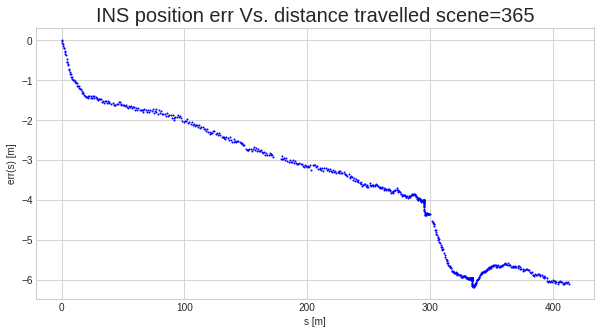

In [131]:
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800
gt = np.zeros(N)
imu = np.zeros(N)
gt_pos = np.zeros((N,2))
imu_pos = np.zeros((N,2))
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt[t] = np.linalg.norm(trns[0:2]-gt_pos[t-1, :]) if t > 0 else 0
    gt_pos[t, :] = trns[0:2]
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    print("gt", trns, "ins", trns1)
    imu[t] = np.linalg.norm(trns1[0:2]-imu_pos[t-1, :]) if t > 0 else 0
    imu_pos[t, :] = trns1[0:2]
    timestamp[t] = dataset.odometry['timestamp']
    
gt_int = np.cumsum(gt)
imu_int = np.cumsum(imu)
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS position err Vs. distance travelled scene={scene}", fontsize=20)
ax.set(xlabel='s [m]', ylabel='err(s) [m]')
ax.scatter(gt_int,gt_int-imu_int,color='blue',s=1)

scene_id=365 scene_name=scene-0451 map_name=boston-seaport
odom_speed [[1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.20000000e+01]
 [1.53728725e+15 1.30000000e+01]
 ...
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]
 [1.53728977e+15 2.60000000e+01]]


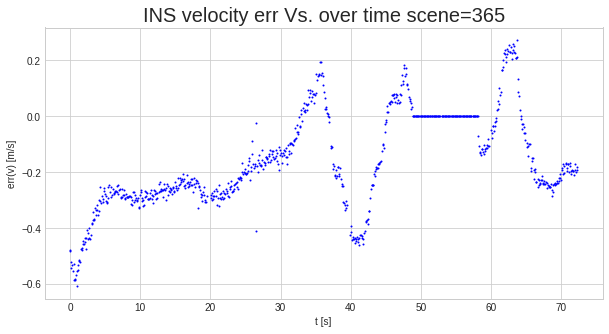

In [134]:
#draw the speed
import scipy
scene = 365
dataset = NuscenesDataset(nusc=nusc, directory=directory,scene_id=scene)
N = 800#800
gt_speed = np.zeros(N)
imu_speed = np.zeros(N)
timestamp = np.zeros(N)
for t in range(0,N):
    trns, rot = dataset.getEgoInfo(dataset.first_idx + t, GT=True)
    gt_speed[t] = np.linalg.norm(dataset.odometry['speed'])
    trns1, rot1 = dataset.getEgoInfo(dataset.first_idx + t, GT=False)
    imu_speed[t] = dataset.odometry['speed']
    timestamp[t] = dataset.odometry['timestamp']
    
fig, ax = plt.subplots(1,figsize=(10,5))
ax.set_title(f"INS velocity err Vs. over time scene={scene}", fontsize=20)
ax.set(xlabel='t [s]', ylabel='err(v) [m/s]')
ax.scatter(timestamp[:]-timestamp[0],gt_speed-imu_speed,color='blue',s=1)

In [ ]:
from pyquaternion import Quaternion

Quaternion.Inverse()

In [ ]:
dataset = NuscenesDataset(nusc=nusc, directory=directory, scene_id=426)
_, _, _, video_data, nusc_map = dataset.getData(700)
map_matching = MapMatching(N=10)

In [ ]:
edges1 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['walkway'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges2 = map_matching.getRoadBorders(nuscMap=nusc_map, worldRef=video_data['pos'], layer_names=['drivable_area'],blur_area=(3,3),threshold1=0.5, threshold2=0.9)
edges = edges1 & edges2

#road = map_matching.getDrivableArea(nuscMap=nusc_map, worldRef=[400,850],layer_names = ['drivable_area'], patch_size=200)
plt.imshow(edges2, origin='lower')

In [ ]:
a = np.array([[1, 2],[3,4],[5,6],[7,8]])
print(a.shape)
b = np.array([[11, 19],[7,28],[15,16]]).T
print(b.shape)
print(a[:,0].shape)
k = a[:,0].reshape(-1,1)-b[0,:].reshape(1,-1)
t = a[:,1].reshape(-1,1)-b[1,:].reshape(1,-1)
norm = np.sqrt(k**2 + t**2)
it = norm.argmin(axis=1)
print("it", it, "norm",norm)
#print(np.amin(norm, axis=1))
print(k.shape, t.shape)
print(k)
print(np.take_along_axis(k, np.expand_dims(it, axis=-1), axis=1))
print(np.take_along_axis(t, np.expand_dims(it, axis=-1), axis=1))

In [30]:
A = np.zeros((3,3))
pnts = [[0,1],[3,3],[6,1]]
dist = np.array([pnt[0]**2 for pnt in pnts])
candidates = np.where(dist>5)[0]
non_candidates = np.where(dist<=5)[0]

A[candidates,0] = 1
print(A)

[[0. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]
